In [840]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [841]:
import cv2
import numpy as np
import math
import glob
import csv
import os
import time
import re
from collections import OrderedDict
import matplotlib.pyplot as plt
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.feature import local_binary_pattern
from skimage import io ,filters,feature,transform

from scipy import stats

from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

In [842]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [843]:
# class LineSegmentor:

#     def __init__(self, gray_img: np.ndarray, bin_img: np.ndarray):
#         """
#         Constructs a new line segmentation object for the given handwritten paragraph image.
#         :param gray_img:    the handwritten paragraph image in gray scale.
#         :param bin_img:     the handwritten paragraph image after binarization.
#         """

#         # Store references to the page images.
#         self.gray_img = gray_img
#         self.bin_img = bin_img

#         # Get horizontal histogram.
#         self.hor_hist = np.sum(bin_img, axis=1, dtype=int) // 255

#         # Get line density thresholds.
#         self.threshold_high = int(np.max(self.hor_hist) // 3)
#         self.threshold_low = 25

#         # Initialize empty lists.
#         self.peaks = []
#         self.valleys = []
#         self.lines_boundaries = []

#         # Calculate peaks and valleys of the page.
#         self.detect_peaks()
#         self.avg_peaks_dist = int((self.peaks[-1] - self.peaks[0]) // len(self.peaks))
#         self.detect_valleys()

#         # Detect missing peaks and valleys in a second iteration.
#         self.detect_missing_peaks_valleys()

#         # Detect line boundaries.
#         self.detect_line_boundaries()

#     def segment(self):
#         """
#         Segments the handwritten paragraph into list of lines.
#         :return:    two lists of lines:
#                     one from the gray image and the other from the binary image.
#         """

#         # # Illustrate line segmentation.
#         # self.display_segmentation()

#         # Initialize lines lists.
#         gray_lines, bin_lines = [], []

#         # Loop on every line boundary.
#         for l, u, r, d in self.lines_boundaries:
#             # Crop gray line.
#             g_line = self.gray_img[u:d + 1, l:r + 1]
#             gray_lines.append(g_line)

#             # Crop binary line.
#             b_line = self.bin_img[u:d + 1, l:r + 1]
#             bin_lines.append(b_line)

#         # Return list of separated lines.
#         return gray_lines, bin_lines

#     def detect_peaks(self):
#         """
#         Detects the peak rows of the image and update self.peaks in correspondence.
#         The peak rows are the ones with the highest black pixel density.
#         """

#         self.peaks = []

#         i = 0
#         while i < len(self.hor_hist):
#             # If the black pixels density of the row is below than threshold
#             # then continue to the next row.
#             if self.hor_hist[i] < self.threshold_high:
#                 i += 1
#                 continue

#             # Get the row with the maximum density from the following
#             # probable row lines.
#             peak_idx = i
#             while i < len(self.hor_hist) and self.is_probable_peak(i):
#                 if self.hor_hist[i] > self.hor_hist[peak_idx]:
#                     peak_idx = i
#                 i += 1

#             # Add peak row index to the list.
#             self.peaks.append(peak_idx)

#     def detect_valleys(self):
#         """
#         Detects the valleys rows of the image and update self.valleys in correspondence.
#         The valleys rows are the ones with the lowest black pixel density
#         between two consecutive peaks.
#         """

#         self.valleys = [0]

#         i = 1
#         while i < len(self.peaks):
#             u = self.peaks[i - 1]
#             d = self.peaks[i]
#             i += 1

#             expected_valley = d - self.avg_peaks_dist // 2
#             valley_idx = u

#             while u < d:
#                 dist1 = np.abs(u - expected_valley)
#                 dist2 = np.abs(valley_idx - expected_valley)

#                 cond1 = self.hor_hist[u] < self.hor_hist[valley_idx]
#                 cond2 = self.hor_hist[u] == self.hor_hist[valley_idx] and dist1 < dist2

#                 if cond1 or cond2:
#                     valley_idx = u

#                 u += 1

#             self.valleys.append(valley_idx)

#         self.valleys.append(len(self.hor_hist) - 1)

#     def detect_missing_peaks_valleys(self):
#         """
#         Detects the missing peaks and valleys after the first detection trial
#         using functions self.detect_peaks and self.detect_valleys.
#         And updates self.peaks and self.valleys in correspondence.
#         The missed peaks and valleys are probably because they are of shorter
#         handwritten lines than the average lines length.
#         """

#         i = 1
#         found = False

#         while i < len(self.valleys):
#             # Calculate distance between two consecutive valleys.
#             up, down = self.valleys[i - 1], self.valleys[i]
#             dis = down - up

#             i += 1

#             # If the distance is about twice the average distance between
#             # two consecutive peaks, then it is most probable that we are missing
#             # a line in between these two valleys.
#             if dis < 1.5 * self.avg_peaks_dist:
#                 continue

#             u = up + self.avg_peaks_dist
#             d = min(down, u + self.avg_peaks_dist)

#             while (d - u) * 2 > self.avg_peaks_dist:
#                 if self.is_probable_valley(u) and self.is_probable_valley(d):
#                     peak = self.get_peak_in_range(u, d)
#                     if self.hor_hist[peak] > self.threshold_low:
#                         self.peaks.append(self.get_peak_in_range(u, d))
#                         found = True

#                 u = u + self.avg_peaks_dist
#                 d = min(down, u + self.avg_peaks_dist)

#         # Re-distribute peaks and valleys if new ones are found.
#         if found:
#             self.peaks.sort()
#             self.detect_valleys()

#     def detect_line_boundaries(self):
#         """
#         Detects handwritten lines of the image using the peaks and valleys.
#         And updates self.lines_boundaries in correspondence.
#         """

#         # Get image dimensions.
#         height, width = self.bin_img.shape

#         self.lines_boundaries = []

#         i = 1
#         while i < len(self.valleys):
#             u = self.valleys[i - 1]
#             d = self.valleys[i]
#             l = 0
#             r = width - 1
#             i += 1

#             while u < d and self.hor_hist[u] == 0:
#                 u += 1
#             while d > u and self.hor_hist[d] == 0:
#                 d -= 1

#             ver_hist = np.sum(self.bin_img[u:d + 1, :], axis=0) // 255

#             while l < r and ver_hist[l] == 0:
#                 l += 1
#             while r > l and ver_hist[r] == 0:
#                 r -= 1

#             self.lines_boundaries.append((l, u, r, d))

#     def calc_average_line_slope(self) -> int:
#         """
#         Calculates the average range slope of the handwritten lines.
#         See self.calc_range_slope for more information.
#         :return:        the average range slope of the lines.
#         """

#         avg_slope = 0

#         i = 1
#         while i < len(self.valleys):
#             u = self.valleys[i - 1]
#             d = self.valleys[i]
#             avg_slope += self.calc_range_slope(u, d)
#             i += 1

#         return int(avg_slope // (len(self.valleys) - 1))

#     def calc_range_slope(self, up: int, down: int) -> int:
#         """
#         Calculates the range slope of black pixels density of the given range.
#         Lets define the following quantities.
#         let d(x)    be the black pixels density at row number x.
#         let d'(x)   be the derivative of d(x) at row x.
#         The range slope is calculated as:
#         range slope = max(d'(i)) - min(d'(i)), where up <= i <= down
#         :param up:      the upper row of the range.
#         :param down:    the lower row of the range.
#         :return:        the range slope.
#         """
#         max_der, min_der = -1e9, 1e9

#         while up < down:
#             up += 1
#             val = self.hor_hist[up] - self.hor_hist[up - 1]
#             max_der = max(max_der, val)
#             min_der = min(min_der, val)

#         return max_der - min_der

#     def get_peak_in_range(self, up: int, down: int) -> int:
#         """
#         Finds the peak row in the given range from up to down inclusive.
#         The peak row is the one with the highest black pixel density.
#         :param up:      the upper row of the range.
#         :param down:    the lower row of the range.
#         :return:        the index of the peak row.
#         """
#         peak_idx = up

#         while up < down:
#             if self.hor_hist[up] > self.hor_hist[peak_idx]:
#                 peak_idx = up
#             up += 1

#         return peak_idx

#     def is_probable_peak(self, row: int) -> bool:
#         """
#         Checks whether the given row is a probable peak row or not.
#         The function depends on heuristics and is not deterministic.
#         :param row:     the index of the row to check.
#         :return:        boolean, whether the row is a probable peak or not.
#         """
#         width = 15

#         for i in range(-width, width):
#             if row + i < 0 or row + i >= len(self.hor_hist):
#                 continue
#             if self.hor_hist[row + i] >= self.threshold_high:
#                 return True

#         return False

#     def is_probable_valley(self, row: int) -> bool:
#         """
#         Checks whether the given row is a probable valley row or not.
#         The function depends on heuristics and is not deterministic.
#         :param row:     the index of the row to check.
#         :return:        boolean, whether the row is a probable valley or not.
#         """
#         width = 30
#         count = 0

#         for i in range(-width, width):
#             if row + i < 0 or row + i >= len(self.hor_hist):
#                 return True
#             if self.hor_hist[row + i] <= self.threshold_low:
#                 count += 1

#         if count * 2 >= width:
#             return True

#         return False

    # def display_segmentation(self):
    #     """
    #     Displays and visualizes segmentation steps.
    #     Used only while debugging.
    #     """

    #     # Display only in debugging mode.
    #     if not DEBUG_LINE_SEGMENTATION:
    #         return

    #     #
    #     # Draw bounding box around segmented lines.
    #     #
    #     img = cv.cvtColor(self.gray_img, cv.COLOR_GRAY2BGR)

    #     for l, u, r, d in self.lines_boundaries:
    #         cv.rectangle(img, (l, u), (r, d), (0, 0, 255), 2)

    #     display_image('Line Segmented Paragraph', img, False)

    #     #
    #     # Draw histogram.
    #     #
    #     plt.figure()
    #     plt.xlabel('Row index')
    #     plt.ylabel('Number of black pixels')
    #     plt.plot(list(range(len(self.hor_hist))), self.hor_hist)
    #     plt.plot([0, len(self.hor_hist)], [self.threshold_high, self.threshold_high], 'g--')

    #     # Draw peaks.
    #     for r in self.peaks:
    #         plt.plot(r, self.hor_hist[r], 'ro')
    #         plt.plot([r - self.avg_peaks_dist / 2, r + self.avg_peaks_dist / 2], [self.hor_hist[r], self.hor_hist[r]], 'r')

    #     # Draw valleys.
    #     for r in self.valleys:
    #         plt.plot(r, self.hor_hist[r], 'bs')

    #     # Draw probable missing valleys
    #     i = 1
    #     while i < len(self.valleys):
    #         dis = self.valleys[i] - self.valleys[i - 1]

    #         if dis > 1.8 * self.avg_peaks_dist:
    #             r = self.valleys[i]
    #             plt.plot(r - self.avg_peaks_dist, self.hor_hist[r], 'gs')

    #         i += 1

    #     plt.draw()
    #     plt.waitforbuttonpress(0)
    #     plt.close()
    #     cv.destroyAllWindows()

In [844]:
def Preprocess(image):
     
    # Remove salt and pepper noise    
    # Remove noise 
    median = cv2.medianBlur(image,5)
    blur = cv2.GaussianBlur(image,(5,5),0)
   
    greyImg = image
    
    # Otsu's Binarization
    ret3,img = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
   
    # Remove header and footer
    length, width = img.shape
    up, down, left, right = 0, length - 1, 0, width - 1

    minWidthOfLines = width/2
    yes,contours,no = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    offsetHeader = 20
    for i in contours:
        x, y, w, h = cv2.boundingRect(i)
        if w < minWidthOfLines:
            continue
        if y < length // 2:
            up = max(up, y + offsetHeader)
        else:
            down = min(down, y - offsetHeader)

    offset = 30
    left = left + offset
    right = right -offset
    noHeaderAndFooter = img[up:down + 1, left:right + 1]
    noHeaderAndFooter = np.asarray(noHeaderAndFooter)
    
    noHeaderAndFooterGrey = greyImg[up:down + 1, left:right + 1]
    noHeaderAndFooterGrey = np.asarray(noHeaderAndFooterGrey) 
   
    # To crop the image
    row, col = noHeaderAndFooter.shape
    tolerance = 15

    sumOfRows = np.sum(noHeaderAndFooter, axis = 1)
    rowIndices = np.where(sumOfRows< (col-tolerance)*255)
    up = np.min(rowIndices)
    down = np.max(rowIndices)

    sumOfColoumns = np.sum(noHeaderAndFooter, axis = 0)
    colIndices = np.where(sumOfColoumns< (row-tolerance)*255)
    left = np.min(colIndices)
    right = np.max(colIndices)

    binarized = noHeaderAndFooter[up:down + 1, left:right + 1]
    binarized = np.asarray(binarized)
    
    greyscale = noHeaderAndFooterGrey[up:down + 1, left:right + 1]
    greyscale = np.asarray(greyscale)
   
    # Segmentation of Lines
    rowIndicesShifted = np.roll(rowIndices, -1)
    rowIndicesShifted = rowIndicesShifted[0]

    transitionIndices = np.where(np.abs(rowIndices - rowIndicesShifted) > 10)
    transitionIndices = transitionIndices[1]

    rowIndices = rowIndices[0]

    downIndices= rowIndices[transitionIndices]

    transitionIndicesUp = np.insert(transitionIndices,0,-1)
    transitionIndicesUp = np.delete(transitionIndicesUp,-1)

    upIndices= rowIndices[transitionIndicesUp+1]
    
    segmentsBinarized = []
    segmentsGrey = []
    totalSize=0
    whiteSpaceTolerance=0.97
    for i in range(transitionIndices.shape[0]):
        currSegment= noHeaderAndFooterGrey[upIndices[i]:downIndices[i] + 1, left:right + 1]
        if((np.sum(currSegment))<(currSegment.shape[0]*currSegment.shape[1]*whiteSpaceTolerance*255)):
            segmentsBinarized.append(noHeaderAndFooter[upIndices[i]:downIndices[i] + 1, left:right + 1])
            segmentsGrey.append(currSegment)
          
    segmentsGrey=np.asarray(segmentsGrey)
    
#     show_images(segmentsGrey)
    # gray_lines, bin_lines = LineSegmentor(greyscale, binarized).segment()
    # gray_lines=np.asarray(gray_lines)
    
    return greyscale, binarized, segmentsBinarized, segmentsGrey
   # return greyscale, binarized, bin_lines, gray_lines

In [845]:
def showHist(imgHist):
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')
    return imgHist[0]

In [846]:
#  Feature Extraction LBP
def LBP(greyscale):
    lbp = local_binary_pattern(greyscale, 8, 4, method='default')
    n_bins =256 
    imgHist = histogram(lbp, n_bins)
    
    return imgHist[0];

In [847]:
# def DiskFractal(img, loops=25):
#     arr = np.zeros((loops, 2))
#     arr[1] = ([np.log(1), np.log(np.sum(255 - img) / 255) - np.log(1)])
#     for x in range(2, loops):
#         img_dilate = cv2.erode(img.copy(), cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * x - 1, 2 * x - 1)),
#                                iterations=1)
#         arr[x] = ([np.log(x), np.log(np.sum(255 - img_dilate) / 255) - np.log(x)])

#     error = 999
#     slope = [0, 0, 0]
#     loops = int(loops)
#     for x in range(2, loops - 2):
#         for y in range(x + 2, loops - 1):
#             first = arr[1:x + 1, :]
#             second = arr[x + 1:y + 1, :]
#             third = arr[y + 1:loops, :]
#             slope1, _, _, _, std_err1 = stats.linregress(x=first[:, 0], y=first[:, 1])
#             slope2, _, _, _, std_err2 = stats.linregress(x=second[:, 0], y=second[:, 1])
#             slope3, _, _, _, std_err3 = stats.linregress(x=third[:, 0], y=third[:, 1])

#             if error > std_err1 + std_err2 + std_err3:
#                 error = std_err1 + std_err2 + std_err3
#                 slope = [slope1, slope2, slope3]

#     return slope

In [848]:
# def AnglesHistogram(image):
#     values, count = np.unique(image, return_counts=True)
#     countBlack = count[0]

#     sob_img_v = np.multiply(filters.sobel_v(image), 255)
#     sob_img_h = np.multiply(filters.sobel_h(image), 255)

#     # Getting angles in radians
#     angles = np.arctan2(sob_img_v, sob_img_h)
#     angles = np.multiply(angles, (180 / math.pi))
#     angles = np.round(angles)

#     anglesHist = []
#     angle1 = 10
#     angle2 = 40

#     while angle2 < 180:
#         anglesCopy = angles.copy()
#         anglesCopy[np.logical_or(anglesCopy < angle1, anglesCopy > angle2)] = 0
#         anglesCopy[np.logical_and(anglesCopy >= angle1, anglesCopy <= angle2)] = 1
#         anglesHist.append(np.sum(anglesCopy))
#         angle1 += 30
#         angle2 += 30

#     return np.divide(anglesHist, countBlack)

In [849]:
def get_slant_angle(img):
    edges = feature.canny(img, sigma=0.6)
    hspace, angles, distances=transform.hough_line(edges)
    accum, angles, dists = transform.hough_line_peaks(hspace, angles, distances)
    angle = np.rad2deg(np.median(angles))
    return angle

In [850]:
def deskew(img):
    thresh=img
    edges = cv2.Canny(thresh,50,200,apertureSize = 3)

#     show_images([edges],['EDGEEEEEEEEEEEEEEEEEEEEEEEEE'])
    lines = cv2.HoughLines(edges,1,np.pi/1000, 55)

    d1 = OrderedDict()
    if lines is None:
        return 0
    for i in range(len(lines)):
        for rho,theta in lines[i]:
            deg = np.rad2deg(theta)
            if deg in d1:
                d1[deg] += 1
            else:
                d1[deg] = 1
                   
    t1 = OrderedDict(sorted(d1.items(), key=lambda x:x[1] , reverse=False))
#     print(list(t1.keys())[0],'Angle' ,thresh.shape)
    angle =list(t1.keys())[0]
    
    return angle

In [851]:
# def fractal_dimension(img, threshold=0.9):
#     Z = 1.0 - img/255
#     def boxcount(Z, k):
#         S = np.add.reduceat(
#             np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
#                                np.arange(0, Z.shape[1], k), axis=1)
#         return len(np.where((S > 0) & (S < k*k))[0])
#     Z = (Z < threshold)
#     print("Z= ",Z)
#     p = min(Z.shape)
#     print("p= ",p)
#     n = 2**np.floor(np.log(p)/np.log(2))
#     print("n1= ",n)
#     n = int(np.log(n)/np.log(2))
#     print("n= ",n)
#     sizes = 2**np.arange(n, 1, -1)
#     print("sizes= ",sizes)
#     counts = []
#     for size in sizes:
#         counts.append(boxcount(Z, size))
#     coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
#     return -coeffs[0]

In [852]:
def extract_features(greyscale1, binarized1, segmentsBinarized1, segmentsGrey1):
    features=[]
    features.extend(LBP(segmentsGrey1))
    #features.extend(AnglesHistogram(segmentsGrey1))
    #features.extend(DiskFractal(segmentsGrey1))
    #features.append(fractal_dimension(segmentsGrey1,threshold=0.25))
#     features.append(get_slant_angle(segmentsGrey1))
  #  features.append(deskew(segmentsGrey1))
    
    return features

In [853]:
def train(folder):
    # print("folder", folder)
    # path=os.path.basename(folder)
    # parent=os.path.basename(os.path.dirname(folder))
    # print("parent= ", parent)
    # trainTime=0
    # feature_vector_all=[]
    # direcs= os.path.join(parent,folder)
    # #direcs = sorted(glob.glob (folder+"/*"))

    
    #path = os.listdir(folder)
    #print("direcs= ", path )
    unused,direcs,files =os.walk(folder)
    for direc in direcs:
        print("direc= ",direc)
        if os.path.isdir(direc):
            print(direc)
            #files = sorted(glob.glob (direc+'/*'))
            #files =sorted(os.listdir(direc+'/*'))
            files=os.listdir(direc)
            print("files ", files)
            for file in files:
                #reading an imag
                print("-----------------------",file,"------------------------------")
                img = cv2.imread(file,0) 
                tempStart =time.time()

                #converting it to a gray image
                #binarization process
                
                greyscale1, binarized1, segmentsBinarized1, segmentsGrey1 = Preprocess(img)
                print(segmentsGrey1.shape)
                for i in range(segmentsGrey1.shape[0]):
                    feature_vector=[]
     
                    z = direc.split('\\')
#                     print(z[1])
                    y= int(z[1])
                    if(y< 100):
                        feature_vector.append(int(direc[8]))
#                         print(int(direc[8]))
                    if(y>=100 and y<1000):
                        feature_vector.append(int(direc[9]))
#                         print(int(direc[9]))
                    if(y>=1000):
                        feature_vector.append(int(direc[10]))
#                         print(int(direc[10])) 
                    
#                     feature_vector.append(int(direc[8]))
                    
                    features =extract_features(greyscale1, binarized1, segmentsBinarized1, segmentsGrey1[i])
                    feature_vector.extend(features)
                    feature_vector_all.append(feature_vector)
                    
                tempEnd =time.time()
                trainTime+= tempEnd-tempStart 

    return feature_vector_all,trainTime

In [854]:
def calculateDistance(x1, x2):

    distance =np.linalg.norm(x1-x2)
    return distance

# def KNN(test_point, training_features, labels, k): 
#     y= labels[ np.argsort(calculateDistance(test_point,training_features))[:k]]
#     l,h = np.unique(y, return_counts=True)
#     return l[np.argmax(h)]

#     distarr=[]
#     for i in range (training_features.shape[0]):
#         f=calculateDistance(training_features[i,:],test_point)
#         distarr.append(f)
        
        
#     sortedarr=np.sort(distarr)
    
#     classes=np.zeros(3)
    
#     for i in range(k):
#         result = np.where(distarr == sortedarr[i])
#         print(result)
#         for j in range(3):
#             if(labels[result[0]]==j+1):
#                 classes[j]+=1
            
            
#     classification=np.argmax(classes)

  
#     return classification+1




In [855]:
def KNN(test_point, training_features, y_train, k):
    class1=0
    class2=0
    class3=0
    dist=[]
    indexs=[]
    
    for i in range(training_features.shape[0]):
        dist.append(calculateDistance(test_point,training_features[i]))
        
    dist2=np.argsort(dist)

    for i in range(k):
        if(y_train[dist2[i]]==1):
            class1=class1+1
        elif(y_train[dist2[i]]==2):
            class2=class2+1
        else:
            class3=class3+1

    if(max(class1,class2,class3)==class1):
        classification=1
    elif(max(class1,class2,class3)==class2):
        classification=2
    else:
        classification=3
    return classification

In [856]:
def SVM(training_features, y_train):
    clf = SVC(kernel='linear', C=6.0)    #linear sigmoid
    clf.fit(training_features, y_train)  
    return clf

In [857]:
# def adaboost_classifier(Y_train, X_train, Y_test, X_test, predictions):

#     M = X_train.shape[0]
#     w = np.full((M,), (1/M))
    
#     classValue = []
#     alpha_t =np.zeros(len(predictions))
        
#     for i in range(len(predictions)): 

#         miss=np.array(1*(predictions[i]==Y_test))

#         err_t = (w*(1-miss)).sum()/(w.sum())
        
#         print((w*(1-miss)).sum())
#         print(w.sum())
#         print(err_t)

#         if(err_t==0):
#             alpha_t[i] = (1)
#             break
#         else if(err_t==1):
#             alpha_t[i]=np.min(w)
#         else:
#             alpha_t[i] = (np.log((1-err_t)/err_t) + np.log(2))

#         w=w*np.exp(alpha_t[i]*(1-miss))
#         w= w/np.linalg.norm(w)    # Normalize weights
        
        
#     for k in range(3):
#         value=0
#         for j in range(len(predictions)):
#             value+=alpha_t[j]*(predictions[j]==k+1)
#         classValue.append(value)
        
#     print("classValue") 
#     print(classValue)
#     return np.argmax(classValue)+1

In [858]:
# def adaboost_classifier(Y_train, training_features,clf,k,ADA_model):     # adaboostof the 3

#     M = training_features.shape[0]
#     w = np.full((M,), (1/M))
    
#     classValue = []
#     knnPredicts = []
#     svmPredicts = []
#     adaPredicts = []
    
    
#     #print(training_features[0])
#     for i in range(M):
#         knnPredicts.append((KNN(training_features[i], training_features, Y_train, k)))
#         svmPredicts.append((clf.predict([training_features[i]])[0]))
#         adaPredicts.append(ADA_model.predict([training_features[i]])[0])
        
      
#     predictions = [knnPredicts,svmPredicts,adaPredicts]
#     alpha_t =np.zeros(len(predictions))

#     for i in range(len(predictions)):  
        
#         miss=np.array(1*(predictions[i]==Y_train))
      

#         err_t = (w*(1-miss)).sum()/(w.sum())
        


#         if(err_t==0):
#             alpha_t[i] = (1)
#             break
#         elif(err_t==1):
#             alpha_t[i]=np.min(w)
#         else:
#             alpha_t[i] = (np.log((1-err_t)/err_t) + np.log(2))

#         w=w*np.exp(alpha_t[i]*(1-miss))
#         w= w/np.linalg.norm(w)    # Normalize weights

        
#     return alpha_t  

def adaboost_classifier(Y_train, training_features,clf,ADA_model):     # adaboost of svm and ada

    M = training_features.shape[0]
    w = np.full((M,), (1/M))
    
    classValue = []
    svmPredicts = []
    adaPredicts = []
    
    
    #print(training_features[0])
    for i in range(M):
        svmPredicts.append((clf.predict([training_features[i]])[0]))
        adaPredicts.append(ADA_model.predict([training_features[i]])[0])
        
      
    predictions = [svmPredicts,adaPredicts]
    alpha_t =np.zeros(len(predictions))

    for i in range(len(predictions)):  
        
        miss=np.array(1*(predictions[i]==Y_train))
      

        err_t = (w*(1-miss)).sum()/(w.sum())
        


        if(err_t==0):
            alpha_t[i] = (1)
            break
        elif(err_t==1):
            alpha_t[i]=np.min(w)
        else:
            alpha_t[i] = (np.log((1-err_t)/err_t) + np.log(2))

        w=w*np.exp(alpha_t[i]*(1-miss))
        w= w/np.linalg.norm(w)    # Normalize weights

        
    return alpha_t 
        
def adaboost_predict (X_test, alpha_t, predictions): 
    classValue = []
    for k in range(3):
        value=0
        for j in range(len(predictions)):
            value+=alpha_t[j]*(predictions[j]==k+1)
        classValue.append(value)
        

    return np.argmax(classValue)+1

In [859]:
def main(directory,true_values,l):
    print(directory)
    training_data,trainTime = train(directory)
    print(training_data)

    training_data = np.asarray(training_data)

    labels = training_data[:,0]
    training_features = training_data[:,1:]
    
    test_images = sorted(glob.glob(directory+'/*.png'))
    
#     true_values.append(int(str(os.path.basename(test_images[0])).split(".")[0]))
#     f3 = open(directory+"/ids.txt", "r")
    
    f3 = open(directory+'/ids.txt')
    ids = f3.readlines()
    ids=np.asarray(ids,dtype=int)
    xtest=ids[-1]
    ytest=np.where(ids==xtest)[0][0]+1 
    true_values.append(ytest)
    f3.close()
    
    k = 5
    knn_prediction = []
    SVM_prediction=[]
    ADA_prediction=[]
    ADA2_prediction=[]
    
    totalTime=[]

    f = open("time.txt", "a")
    f2= open("results.txt","a")
    
    clf= SVM(training_features,labels)
    
    ada = AdaBoostClassifier(n_estimators=50, learning_rate=0.5)    #ADA
    ADA_model = ada.fit(training_features, labels)
    
    alpha_t = adaboost_classifier(labels, training_features,clf, ADA_model)    # ADA2
    
   
    for i in range(len(test_images)):
    
        img_original = cv2.imread(test_images[i],0)
        start = time.time()
        greyscale1, binarized1, segmentsBinarized1, segmentsGrey1 = Preprocess(img_original)
        maxOccurSegment=[]
        maxOccurSegmentSVM=[]
        maxOccurSegmentADA=[]
        maxOccurSegmentADA2=[]
        print("Actual class :", true_values[l], " of file ", test_images[i])
        print("---------------------------------------")
        for j in range(segmentsGrey1.shape[0]):
            test_point = extract_features(greyscale1, binarized1, segmentsBinarized1, segmentsGrey1[j])

            maxOccurSegment.append(int(KNN(test_point, training_features, labels, k)))
            maxOccurSegmentSVM.append(int(clf.predict([test_point])[0]))  #SVM
            maxOccurSegmentADA.append(int(ADA_model.predict([test_point])[0]))  #ADA
            
            predictions = [maxOccurSegmentSVM[j], maxOccurSegmentADA[j]]
#             maxOccurSegmentADA2.append(adaboost_classifier(labels, training_features, true_values[l], test_point, predictions)) #ADA2 #
            maxOccurSegmentADA2.append(adaboost_predict(test_point, alpha_t, predictions)) #ADA2 #


        maxOccurSegment=np.asarray(maxOccurSegment)
        maxOccurSegmentSVM=np.asarray(maxOccurSegmentSVM)
        maxOccurSegmentADA=np.asarray(maxOccurSegmentADA)
        maxOccurSegmentADA2=np.asarray(maxOccurSegmentADA2)

        print(maxOccurSegment)
        print(maxOccurSegmentSVM)
        print(maxOccurSegmentADA)
        print(maxOccurSegmentADA2)
        
        knn_prediction.append(np.bincount(maxOccurSegment).argmax())
        SVM_prediction.append(np.bincount(maxOccurSegmentSVM).argmax())
        ADA_prediction.append(np.bincount(maxOccurSegmentADA).argmax())
        ADA2_prediction.append(np.bincount(maxOccurSegmentADA2).argmax())
        
        end = time.time()
        predictionTime= end-start
        totalTime.append(trainTime+ predictionTime)

        f.write(str(round(totalTime[i],2)))
        f.write("\n")

        f2.write(str(knn_prediction[i]))
        f2.write("\n")


        
        print("knn_prediction class :", knn_prediction[i])
        print("SVM_prediction class :", SVM_prediction[i])
        print("ADA_prediction class :", ADA_prediction[i])
        print("ADA2_prediction class :", ADA2_prediction[i])
        # ------------------------------------------------------------------------------------------------------

#     f.write("------------------------------------")
#     totalTime=np.asarray(totalTime)
#     f.write(str(np.mean(totalTime)))
    f.close()
    f2.close()

    
    return knn_prediction, SVM_prediction, ADA_prediction, ADA2_prediction, totalTime

In [860]:
#direcs = sorted(glob.glob ("data/*"))
#path= "C:/Users/farah/Desktop/Fall 2020/Pattern/Project/Writer-Identification-System/data"
folderName= "data"
direcs =os.listdir(folderName)
print(len(direcs))
direcs2= sorted(direcs,key=int)
print(len(direcs2))
true_values = []
knn_prediction = []
SVM_prediction=[]
ADA_prediction=[]
ADA2_prediction=[]
totalTime=[]

for l in range(len(direcs2)):
    newPath= os.path.join(path,str(direcs2[l]))
    knn_predict, SVM_predict, ADA_predict, ADA2_predict, timeTest  = main(newPath,true_values,l)
    knn_prediction.append(knn_predict[0])
    SVM_prediction.append(SVM_predict[0])
    ADA_prediction.append(ADA_predict[0])
    ADA2_prediction.append(ADA2_predict[0])
    totalTime.append(timeTest[0])
 
f4 = open("time.txt", "a")
totalTime=np.asarray(totalTime)
f4.write(str(np.mean(totalTime)))   
f4.close()

150
150
C:/Users/farah/Desktop/Fall 2020/Pattern/Project/Writer-Identification-System/data\00


ValueError: too many values to unpack (expected 3)

In [603]:
total_predictions =  len(direcs)
correct_knn=0
correct_SVM=0
correct_ADA=0
correct_ADA2=0

print(true_values)
print(knn_prediction)
print(SVM_prediction)
print(ADA_prediction)
print(ADA2_prediction)
for i in range(total_predictions):
    if(true_values[i]==knn_prediction[i]):
        correct_knn=correct_knn+1
    if(true_values[i]==SVM_prediction[i]):
        correct_SVM=correct_SVM+1
    if(true_values[i]==ADA_prediction[i]):
        correct_ADA=correct_ADA+1
    if(true_values[i]==ADA2_prediction[i]):
        correct_ADA2=correct_ADA2+1   


accuracy_knn = (correct_knn/total_predictions)*100
accuracy_SVM = (correct_SVM/total_predictions)*100
accuracy_ADA = (correct_ADA/total_predictions)*100
accuracy_ADA2 = (correct_ADA2/total_predictions)*100
# ------------------------------------------------------------------------------------------------------

print("K-Nearest Neighbour Classifier Accuracy: ", accuracy_knn, "%")
print("SVM Classifier Accuracy: ", accuracy_SVM, "%")
print("ADA Classifier Accuracy: ", accuracy_ADA, "%")
print("ADA2 Classifier Accuracy: ", accuracy_ADA2, "%")

[3, 2, 1, 1, 3, 2, 1, 2, 1, 3, 3, 1, 1, 3, 2, 2, 3, 2, 3, 3, 1, 3, 1, 2, 2, 3, 3, 3, 2, 1, 2, 1, 3, 1, 2, 3, 3, 3, 1, 1, 2, 2, 3, 1, 2, 3, 3, 1, 3, 2, 2, 3, 3, 1, 1, 1, 2, 3, 2, 1, 3, 1, 3, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 2, 1, 2, 1, 3, 3, 1, 2, 3, 3, 1, 3, 1, 3, 1, 2, 3, 2, 2, 2, 1, 1, 1, 3, 3, 1, 2, 2, 1, 3, 3, 3, 2, 3, 3, 1, 3, 3, 1, 2, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 1, 1, 3, 2, 3, 1, 1, 2, 3, 1, 3, 2, 1, 3, 2, 1, 2, 2, 1, 3, 3, 1]
[1, 2, 1, 1, 3, 2, 1, 2, 1, 1, 3, 1, 1, 3, 2, 2, 1, 1, 3, 3, 3, 3, 1, 2, 2, 3, 3, 3, 2, 1, 2, 1, 3, 1, 2, 3, 2, 3, 1, 1, 2, 2, 3, 1, 2, 3, 3, 1, 3, 2, 1, 3, 3, 1, 1, 1, 2, 3, 2, 1, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 2, 1, 2, 1, 3, 1, 1, 2, 3, 2, 1, 3, 3, 3, 1, 2, 3, 2, 2, 2, 1, 2, 1, 3, 3, 1, 2, 2, 1, 3, 3, 3, 2, 3, 3, 1, 3, 3, 1, 2, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 1, 1, 3, 2, 1, 1, 1, 2, 3, 1, 3, 1, 1, 3, 2, 1, 2, 3, 1, 3, 3, 1]
[3, 2, 1, 1, 3, 2, 1, 2, 1, 3, 3, 1, 1, 3, 2, 2, 3, 2, 3, 3, 1, 3, 1, 2, 2, 3, 3, 3, 2, 1, 2, 1, 3

In [604]:
# img = cv2.imread('a01-063.png',0) 
# greyscale1, binarized1, segmentsBinarized1, segmentsGrey1 = Preprocess(img)

In [605]:
# def fractal_dimension(img, threshold=0.9):
#     Z = 1.0 - img/255
#     def boxcount(Z, k):
#         S = np.add.reduceat(
#             np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
#                                np.arange(0, Z.shape[1], k), axis=1)
#         return len(np.where((S > 0) & (S < k*k))[0])
#     Z = (Z < threshold)
#     p = min(Z.shape)
#     n = 2**np.floor(np.log(p)/np.log(2))
#     n = int(np.log(n)/np.log(2))
#     sizes = 2**np.arange(n, 1, -1)
#     counts = []
#     for size in sizes:
#         counts.append(boxcount(Z, size))
#     coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
#     return -coeffs[0]


# # Z = 1.0 - misc.imread("../data/Great-Britain.png")/255
# img = cv2.imread('1.png',0) 
# greyscale1, binarized1, segmentsBinarized1, segmentsGrey1 = Preprocess(img)
# for i in range(len(segmentsGrey1)):
#     print(fractal_dimension(segmentsGrey1[i], threshold=0.25))


In [606]:
# sizes = 2**np.arange(1, 1, -1)
# print(sizes)

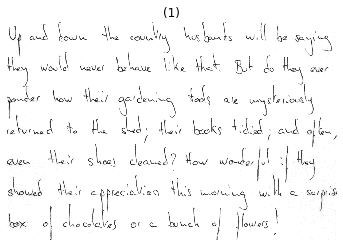

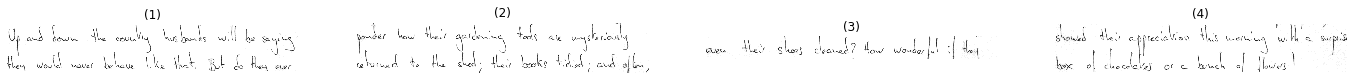

In [607]:
img = cv2.imread('b04-103.png',0) 
greyscale1, binarized1, segmentsBinarized1, segmentsGrey1 = Preprocess(img)
show_images([greyscale1])
show_images(segmentsGrey1)